# Infer ***nuclei*** - 1️⃣ 

--------------

## OBJECTIVE: 
### ✅ Infer sub-cellular component #1: ***nuclei***  in order to understand interactome 

To measure shape, position, size, and interaction of eight organelles/cellular components ***nuclei***.  

Dependencies:
***Soma*** and ***cytoplasm*** inference rely on the ***nuclei*** inference.  Therefore all of the sub-cellular objects rely on the NU segmentation.


> CONVENTION:  "nuclei" for the segmentation of ALL nuclei in the image.  "nucleus" for the ***single*** cellmask-masked version.


## preamble

1. imports
2. setup
3. ~~choose_Z~~
4. get cellmask mask (if available)
5. infer-nuclei
    * input
    * pre-processing
    * core processing
    * post-processing
    * output
6. infer _nucleus_ : apply cellmask mask (if not available at #4)





### IMPORTS

In [21]:
# top level imports
from pathlib import Path
import os, sys
from collections import defaultdict
from typing import Optional, Union

import numpy as np

from aicssegmentation.core.pre_processing_utils import  image_smoothing_gaussian_slice_by_slice 
from skimage.measure import label

# # package for io 
from aicsimageio import AICSImage

import napari

### import local python functions in ../infer_subc_2d
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))

from infer_subc_2d.core.file_io import (read_czi_image,
                                                                    export_inferred_organelle,
                                                                    list_image_files)

from infer_subc_2d.core.img import *


%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# NOTE:  these "constants" are only accurate for the testing MCZ dataset
from infer_subc_2d.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROX_CH ,
                                                                    ER_CH ,
                                                                    LD_CH ,
                                                                    RESIDUAL_CH )                       


## SETUP


CUSTOMIZE WITH: 
1. updated path to data
2. updated folder name for "raw" data

> NOTE: we are operating on a single "test" image in this notebook.  The batch-processing of all the images will be happen at the end of the notebook after we have developed/confirmed the setmentation procedures and parameter settings.


In [23]:
# this will be the example image for testing the pipeline below
test_img_n = TEST_IMG_N

# build the datapath
# all the imaging data goes here.
data_root_path = Path(os.path.expanduser("~")) / "Projects/Imaging/data"

# linearly unmixed ".czi" files are here
in_data_path = data_root_path / "raw"
im_type = ".czi"

# get the list of all files
img_file_list = list_image_files(in_data_path,im_type)
test_img_name = img_file_list[test_img_n]

# save output ".tiff" files here
out_data_path = data_root_path / "out"

if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

In [24]:
img_data,meta_dict = read_czi_image(test_img_name)

# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']


/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


## infer ***nuclei***
 

## summary of steps

➡️ INPUT

- channel 0

PRE-PROCESSING
-  scale to min 0, max 1.0
- median Filter window 4
-  gaussian 1.34

CORE-PROCESSING
  - threshold method minimum cross-entropy.  
    - objects 50-400 pixels, 
    - threshold smoothing scale: 1.34 (later 1 pixel
    - threshold correction factor: 0.9 (later 1.2 )
    - lower / upper bounds  (.1,1) ?
    - log transformed thresholding
    - fill holes


POST-PROCESSING
  - fill holes
  - remove small objects


OUTPUT ➡️ 
- labels of NUCLEI


> #### Note:  in later steps we will limit each analysis to a single object, but at this stage we have multiple

NOTE:  using Allen Cell Segmenter  [Nucleophosmin](https://www.allencell.org/cell-observations/category/nucleophosmin) might be a good generic mechanism.  e.g.
-  [playground_npm1.ipynb](https://github.com/AllenInstitute/aics-segmentation/blob/master/lookup_table_demo/playground_npm1.ipynb) and [npm1.py](https://github.com/AllenInstitute/aics-segmentation/blob/master/aicssegmentation/structure_wrapper/seg_npm1.py) and [npm1_SR.py](https://github.com/AllenInstitute/aics-segmentation/blob/master/aicssegmentation/structure_wrapper/seg_npm1_SR.py)


> #### Note:  this initial inferred object -- the ***nuclei*** of the brightest cell -- is implicitly used in inferring the ***cellmask*** and ***cytoplasm*** objects.  


## INPUT prototype

Get the "raw" signals we need to analyze as well as any other dependencies in "inferred" objects.  

> NOTE: we are operating on a single "test" image in this notebook.  The batch-processing of all the images will be happen at the end of the notebook after we have developed/confirmed the setmentation procedures and parameter settings.

In [25]:
###################
# INPUT
###################
raw_nuclei = select_channel_from_raw(img_data, NUC_CH)


## PRE-PROCESSING prototype


In [26]:
###################
# PRE_PROCESSING
###################           
# 
med_filter_size = 4   
gaussian_smoothing_sigma = 1.34
# nuclei = min_max_intensity_normalization(raw_nuclei )
# nuclei = median_filter_slice_by_slice( nuclei, size=med_filter_size  )
# nuclei = image_smoothing_gaussian_slice_by_slice(  nuclei, sigma=gaussian_smoothing_sigma)

nuclei =  scale_and_smooth(raw_nuclei,
                                                    median_sz = med_filter_size, 
                                                    gauss_sig = gaussian_smoothing_sigma)


> #### ASIDE: Thresholding
> [Thresholding](https://en.wikipedia.org/wiki/Thresholding_%28image_processing%29) is used to create binary images. A threshold value determines the intensity value separating foreground pixels from background pixels. Foregound pixels are pixels brighter than the threshold value, background pixels are darker. In many cases, images can be adequately segmented by thresholding followed by labelling of *connected components*, which is a fancy way of saying "groups of pixels that touch each other".
> 
> Different thresholding algorithms produce different results. [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method) and [Li's minimum cross entropy threshold](https://scikit-image.org/docs/dev/auto_examples/developers/plot_threshold_li.html) are two common algorithms. Below, we use Li. You can use `skimage.filters.threshold_<TAB>` to find different thresholding methods.

_Li_ procedure  better matches the CellProfiler pipeline which simply calls it "Minimum Cross Entropy" .


## CORE PROCESSING prototype

In [27]:
###################
# CORE_PROCESSING
###################

threshold_factor = 0.9 #from cellProfiler
thresh_min = .1
thresh_max = 1.
li_thresholded = apply_log_li_threshold(nuclei, thresh_factor=threshold_factor, thresh_min=thresh_min, thresh_max=thresh_max)


## POST PROCESSING prototype

> NOTE: the size parameters are by convention defined as one dimensional "width", so the inputs to the functions need to be _squared_ i.e. raised to the power of 2: `** 2`.   For volumetric (3D) analysis this would be _cubed_:`**3`

In [28]:
###################
# POST_PROCESSING
###################

hole_width = 25  
# # wrapper to remoce_small_objects
#removed_holes = remove_small_holes(li_thresholded, hole_width ** 2 )
removed_holes = hole_filling_linear_size(li_thresholded, hole_min=0, hole_max=hole_width)

small_object_width = 15
cleaned_img = size_filter_linear_size(removed_holes, # wrapper to remove_small_objects which can do slice by slice
                                                                min_size= small_object_width)

cleaned_img2 = fill_and_filter_linear_size(li_thresholded, hole_min=0, hole_max=hole_width, min_size= small_object_width)

In [29]:
nuclei_object = cleaned_img
NU_labels = label( cleaned_img )
NU_signal = raw_nuclei


## Visualize with `napari` 1
Visualize the first-pass segmentation and labeling with `napari`.

In [30]:
viewer = napari.Viewer()


In [31]:

viewer.add_image(
    nuclei_object,
    opacity=0.3,
)    


viewer.add_labels(
    NU_labels,
    opacity=0.3,
)



<Labels layer 'NU_labels' at 0x13b94f190>

## SAVE inferred nuclei to .tif file

Based on the _prototyping_ above define the function to infer nuclei.  


In [32]:


out_file_n = export_inferred_organelle(nuclei_object, "nuclei", meta_dict, out_data_path)


>>>>>>>>>>>> tifffile.imwrite in (0.04) sec
saved file: None


## DEFINE `_infer_nuclei_fromlabel` function

Based on the _prototyping_ above define the function to infer nuclei.  


In [33]:
##########################
#  _infer_nuclei
##########################
def _infer_nuclei_fromlabel( in_img: np.ndarray, 
                            nuc_ch: Union[int,None],
                            median_sz: int, 
                            gauss_sig: float,
                            thresh_factor: float,
                            thresh_min: float,
                            thresh_max: float,
                            max_hole_w: int,
                            small_obj_w: int
                        ) -> np.ndarray:
    """
    Procedure to infer nuclei from linearly unmixed input.

    Parameters
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels
    median_sz: int
        width of median filter for signal
    gauss_sig: float
        sigma for gaussian smoothing of  signal
    thresh_factor: float
        adjustment factor for log Li threholding
    thresh_min: float
        abs min threhold for log Li threholding
    thresh_max: float
        abs max threhold for log Li threholding
    max_hole_w: int
        hole filling cutoff for nuclei post-processing
    small_obj_w: int
        minimu object size cutoff for nuclei post-processing

    Returns
    -------------
    nuclei_object
        mask defined extent of NU
    
    """

    ###################
    # PRE_PROCESSING
    ###################                
    if nuc_ch is None:
        nuc_ch = NUC_CH

    nuclei = select_channel_from_raw(in_img, nuc_ch)

    nuclei =  scale_and_smooth(nuclei,
                        median_sz = median_sz, 
                        gauss_sig = gauss_sig)

    ###################
    # CORE_PROCESSING
    ###################
    nuclei_object = apply_log_li_threshold(nuclei, 
                                                                    thresh_factor=thresh_factor, 
                                                                    thresh_min=thresh_min, 
                                                                    thresh_max=thresh_max)

    ###################
    # POST_PROCESSING
    ###################
    nuclei_object = fill_and_filter_linear_size(nuclei_object, hole_min=0, hole_max=max_hole_w, min_size= small_obj_w)
    return nuclei_object


## DEFINE `_fixed_infer_nuclei` function


In [34]:
##########################
#  fixed_infer_nuclei
##########################
def _fixed_infer_nuclei(in_img: np.ndarray) -> np.ndarray:
    """
    Procedure to infer cellmask from linearly unmixed input, with a *fixed* set of parameters for each step in the procedure.  i.e. "hard coded"

    Parameters
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels
 
    Returns
    -------------
    nuclei_object
        inferred nuclei
    
    """
    nuc_ch = NUC_CH
    median_sz = 4   
    gauss_sig = 1.34
    threshold_factor = 0.9
    thresh_min = 0.1
    thresh_max = 1.0
    max_hole_w = 25
    small_obj_w = 15

    return _infer_nuclei_fromlabel( in_img,
                                    nuc_ch,
                                    median_sz,
                                    gauss_sig,
                                    threshold_factor,
                                    thresh_min,
                                    thresh_max,
                                    max_hole_w,
                                    small_obj_w  )


---------------------
## TEST `_infer_nuclei`  function defined above


In [35]:

_NU_object =  _fixed_infer_nuclei(img_data) 


---------------------
# TEST `infer_nuclei_fromlabel` exported functions

> the prototype `_infer_nuclei` was copied to the [`.organelles.nuclei`](../infer_subc_2d/organelles/nuclei.py) sub-module 
##
`infer_nuclei_fromlabel` procedure

Use the `infer_nuclei_fromlabel` function to infer the Nucleus and export it as an _ome.tif_ for easy reference.

In [36]:
from infer_subc_2d.organelles.nuclei import infer_nuclei_fromlabel, fixed_infer_nuclei
nuclei_object =  fixed_infer_nuclei(img_data) 


 in_img = (8, 16, 768, 768)
nuclei size = (16, 768, 768)


## Visualize  2


In [37]:
viewer.add_image(
    _NU_object,
    opacity=0.3,
)    


viewer.add_labels(
    label(_NU_object),
    opacity=0.3,
)


<Labels layer 'Labels' at 0x161cf8c10>

In [38]:
viewer.add_image(
    nuclei_object,
    opacity=0.3,
)    


<Image layer 'nuclei_object [1]' at 0x161cf8ac0>

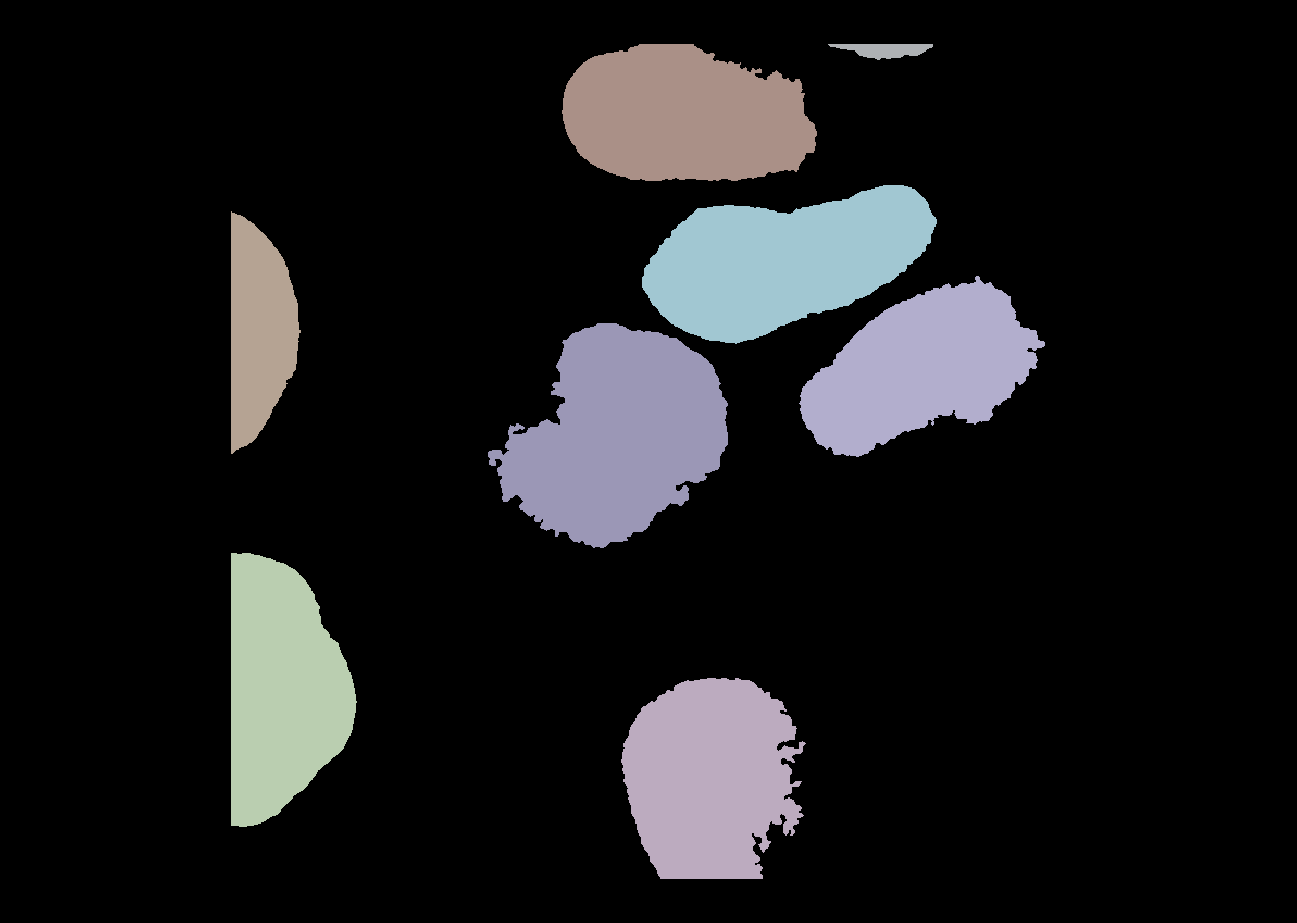

In [39]:
from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)


In [40]:
viewer.close()

-------------
## SUMMARY

The above explains the overall framework.  

### NEXT: INFER CELLMASK

proceed to [02_infer_cellmask.ipynb](./02_infer_cellmask.ipynb)
